### Parts-of-Speech Tagging (POS)

Part-of-speech (POS) tagging is the process of assigning a part-of-speech tag (Noun, Verb, Adjective...) to each word in an input text.  Tagging is difficult because some words can represent more than one part of speech at different times. They are  **Ambiguous**. Let's look at the following example: 

- The whole team played **well**. [adverb]
- You are doing **well** for yourself. [adjective]
- **Well**, this assignment took me forever to complete. [interjection]
- The **well** is dry. [noun]
- Tears were beginning to **well** in her eyes. [verb]


- Learn how parts-of-speech tagging works
- Compute the transition matrix A in a Hidden Markov Model
- Compute the transition matrix B in a Hidden Markov Model
- Compute the Viterbi algorithm 
- Compute the accuracy of your own model 


In [1]:
import pandas as pd
from collections import defaultdict
import math
import numpy as np
import string

In [12]:
'In\tIN\n'.split()

['In', 'IN']

In [2]:
# create vocab from the tarining data and save it in the file (hmm_vocab.txt)
from collections import Counter
with open("D:/Jan July 2023/NLP/Code/2. POS_Tagging/WSJ_02-21.pos", 'r') as f:
    lines = f.readlines()
print(lines[:5])
words = [line.split('\t')[0] for line in lines]
freq= Counter(words)
vocab= [key for key, value in freq.items() if (value > 2 and key!='\n')]
vocab.sort()

['In\tIN\n', 'an\tDT\n', 'Oct.\tNNP\n', '19\tCD\n', 'review\tNN\n']


In [3]:
for i, item in enumerate(freq.items()):
    print(item)
    if i>5:
        break

('In', 1740)
('an', 3143)
('Oct.', 318)
('19', 100)
('review', 58)
('of', 22929)
('``', 6967)


In [15]:
# print(vocab[1000:1500])

## Hanlding unknown tokens
A POS tagger will always encounter words that are not within the vocabulary that is being used. By augmenting the dataset to include these `unknown word tokens` you are helping the tagger to have a better idea of the appropriate tag for these words. 

To tackle this, you can simply classify each new word as an unknown one, but you can do better by creating a function that tries to classify the type of each unknown word and assign it a corresponding `unknown token`. 

This function will do the following checks and return an appropriate token:

   - Check if the unknown word contains any character that is a digit 
       - return `--unk_digit--`
   - Check if the unknown word contains any punctuation character 
       - return `--unk_punct--`
   - Check if the unknown word contains any upper-case character 
       - return `--unk_upper--`
   - Check if the unknown word ends with a suffix that could indicate it is a noun, verb, adjective or adverb 
        - return `--unk_noun--`, `--unk_verb--`, `--unk_adj--`, `--unk_adv--` respectively

If a word fails to fall under any condition then its token will be a plain `--unk--`. The conditions will be evaluated in the same order as listed here. So if a word contains a punctuation character but does not contain digits, it will fall under the second condition. 

any function returns `True` if at least one of the cases it evaluates is `True`.

In [16]:
print(set(string.punctuation))

{'%', '$', '-', '{', '[', ',', "'", '*', ':', '/', '}', ')', '`', '~', '<', '&', '=', '>', '!', '+', '|', '"', '.', '(', '#', '_', ';', ']', '\\', '?', '@', '^'}


In [4]:
def assign_unk(word):

    punct = set(string.punctuation)
    
    # Suffixes
    noun_suffix = ["action", "age", "ance", "cy", "dom", "ee", "ence", "er", "hood", "ion", "ism", "ist", "ity", "ling", "ment", "ness", "or", "ry", "scape", "ship", "ty"]
    verb_suffix = ["ate", "ify", "ise", "ize"]
    adj_suffix = ["able", "ese", "ful", "i", "ian", "ible", "ic", "ish", "ive", "less", "ly", "ous"]
    adv_suffix = ["ward", "wards", "wise"]

    if any(char.isdigit() for char in word):
        return "--unk_digit--"
    
    elif any(char in punct for char in word):
        return "--unk_punct--"
    
    elif any(char.isupper() for char in word):
        return "--unk_upper--"

    elif any(word.endswith(suffix) for suffix in noun_suffix):
        return "--unk_noun--"

    elif any(word.endswith(suffix) for suffix in verb_suffix):
        return "--unk_verb--"

    elif any(word.endswith(suffix) for suffix in adj_suffix):
        return "--unk_adj--"

    elif any(word.endswith(suffix) for suffix in adv_suffix):
        return "--unk_adv--"
    
    return "--unk--"

In [18]:
print('\n'.split())

[]


In [5]:
def get_word_tag(line, vocab):
    # If line is empty return placeholders for word and tag
    if not line.split():
        word = "--n--"
        tag = "--s--"
    else:
        word, tag = line.split()
#         Handling unknown words 
        if word not in vocab: 
            word = assign_unk(word)
    return word, tag

In [20]:
get_word_tag('\n', vocab)

('--n--', '--s--')

In [21]:
get_word_tag('In\tIN\n', vocab)

('In', 'IN')

In [22]:
get_word_tag('tardigrade\tNN\n', vocab)

('--unk--', 'NN')

In [6]:
def preprocess(vocab, data_fp):
    orig = []
    prep = []

    with open(data_fp, "r") as data_file:

        for cnt, word in enumerate(data_file):
#             cnt=0, word='The'
#             word= '\n'
            if not word.split():
                orig.append(word.strip())
                word = "--n--"
                prep.append(word)
                continue

            # Handle unknown words
# 
            elif word.strip() not in vocab:
                orig.append(word.strip())
                word = assign_unk(word)
                prep.append(word)
                continue

            else:
 #             word='The'
                orig.append(word.strip())
                prep.append(word.strip())

    assert(len(orig) == len(open(data_fp, "r").readlines()))
    assert(len(prep) == len(open(data_fp, "r").readlines()))

    return orig, prep

<a name='0'></a>
## Part 0: Data Sources
use two tagged data sets collected from the **Wall Street Journal (WSJ)**. 

[Here](http://relearn.be/2015/training-common-sense/sources/software/pattern-2.6-critical-fork/docs/html/mbsp-tags.html) is an example 'tag-set' or Part of Speech designation describing the two or three letter tag and their meaning. 
- One data set (**WSJ-2_21.pos**) will be used for **training**.
- The other (**WSJ-24.pos**) for **testing**. 
- The tagged training data will be  preprocessed to form a vocabulary (**hmm_vocab.txt**). 
- The words in the vocabulary are words from the training set that were used two or more times. 
- The vocabulary is augmented with a set of 'unknown word tokens'

The training set will be used to create the emission, transmission and tag counts. 

The test set (WSJ-24.pos) is read in to create `y`. 
- This contains both the test text and the true tag. 
- The test set has also been preprocessed to remove the tags to form **test_words.txt**. 
- This is read in and further processed to identify the end of sentences and handle words not in the vocabulary using functions provided in **utils_pos.py**. 
- This forms the list `prep`, the preprocessed text used to test our  POS taggers.

A POS tagger will necessarily encounter words that are not in its datasets. 
- To improve accuracy, these words are further analyzed during preprocessing to extract available hints as to their appropriate tag. 
- For example, the suffix 'ize' is a hint that the word is a verb, as in 'final-ize' or 'character-ize'. 
- A set of unknown-tokens, such as '--unk-verb--' or '--unk-noun--' will replace the unknown words in both the training and test corpus and will appear in the emission, transmission and tag data structures.


In [7]:
# load training data
with open("D:/Jan July 2023/NLP/Code/2. POS_Tagging/WSJ_02-21.pos", 'r') as f:
    training_corpus = f.readlines()
# load vocab
with open("D:/Jan July 2023/NLP/Code/2. POS_Tagging/hmm_vocab.txt", 'r') as f:
    voc_l = f.read().split('\n')

In [25]:
voc_l[:10]

['!', '#', '$', '%', '&', "'", "''", "'40s", "'60s", "'70s"]

In [8]:
# create vocab: dictionary that has the index of the corresponding words
vocab = {} 
for i, word in enumerate(sorted(voc_l)): 
    vocab[word] = i       

In [9]:
print("Vocabulary dictionary, key is the word, value is a unique integer")
cnt = 0
for k,v in vocab.items():
    print(f"{k}:{v}")
    cnt += 1
    if cnt > 5:
        break

Vocabulary dictionary, key is the word, value is a unique integer
:0
!:1
#:2
$:3
%:4
&:5


In [10]:
# load in the test corpus
with open("D:/Jan July 2023/NLP/Code/2. POS_Tagging/WSJ_24.pos", 'r') as f:
    y = f.readlines()
print(y[0:10])

['The\tDT\n', 'economy\tNN\n', "'s\tPOS\n", 'temperature\tNN\n', 'will\tMD\n', 'be\tVB\n', 'taken\tVBN\n', 'from\tIN\n', 'several\tJJ\n', 'vantage\tNN\n']


In [11]:
#corpus without tags, preprocessed
ori, prep = preprocess(vocab, "D:/Jan July 2023/NLP/Code/2. POS_Tagging/test.words")     
print(prep[600:800])

['rebound', 'in', 'permits', 'for', 'multifamily', 'units', 'signaled', 'an', 'increase', 'in', 'September', 'starts', ',', 'though', 'activity', 'remains', 'fairly', 'modest', 'by', 'historical', 'standards', '.', '--n--', '--unk_punct--', 'Street', '--n--', 'If', 'the', '--unk_punct--', '--unk_punct--', 'law', "'s", 'fair', ',', 'Why', 'should', 'we', 'not', 'then', 'amend', 'the', '--unk--', 'To', 'require', 'that', 'all', 'employees', 'give', 'Similar', 'notice', 'before', 'they', 'quit', '?', '--n--', '--', '--unk_upper--', 'S.', '--unk_upper--', '.', '--n--', '--unk_upper--', '--unk_upper--', '--n--', 'When', 'research', 'projects', 'are', 'curtailed', 'due', 'to', 'government', 'funding', 'cuts', ',', 'are', 'we', '``', 'caught', 'with', 'our', 'grants', 'down', "''", '?', '--n--', '--', '--unk_punct--', 'Friedman', '.', '--n--', 'Assuming', 'the', 'stock', 'market', 'does', "n't", 'crash', 'again', 'and', 'completely', '--unk--', 'yuppies', 'and', 'trading', 'rooms', ',', 'Amer

In [30]:
print(ori[600:800])

['rebound', 'in', 'permits', 'for', 'multifamily', 'units', 'signaled', 'an', 'increase', 'in', 'September', 'starts', ',', 'though', 'activity', 'remains', 'fairly', 'modest', 'by', 'historical', 'standards', '.', '', 'Two-Way', 'Street', '', 'If', 'the', 'sixty-day', 'plant-closing', 'law', "'s", 'fair', ',', 'Why', 'should', 'we', 'not', 'then', 'amend', 'the', 'writ', 'To', 'require', 'that', 'all', 'employees', 'give', 'Similar', 'notice', 'before', 'they', 'quit', '?', '', '--', 'Rollin', 'S.', 'Trexler', '.', '', 'Candid', 'Comment', '', 'When', 'research', 'projects', 'are', 'curtailed', 'due', 'to', 'government', 'funding', 'cuts', ',', 'are', 'we', '``', 'caught', 'with', 'our', 'grants', 'down', "''", '?', '', '--', 'C.E.', 'Friedman', '.', '', 'Assuming', 'the', 'stock', 'market', 'does', "n't", 'crash', 'again', 'and', 'completely', 'discredit', 'yuppies', 'and', 'trading', 'rooms', ',', 'American', 'television', 'audiences', 'in', 'a', 'few', 'months', 'may', 'be', 'seein

## Part 1- Train a model without HMM
Training
You will start with the simplest possible parts-of-speech tagger and we will build up to the state of the art. 

In this section, you will find the words that are not ambiguous. 
- For example, the word `is` is a verb and it is not ambiguous. 
- In the `WSJ` corpus, $86$% of the token are unambiguous (meaning they have only one tag) 
- About $14\%$ are ambiguous (meaning that they have more than one tag)

Before you start predicting the tags of each word, we will need to compute a few dictionaries that will help you to generate the tables. 

#### Transition counts
- The first dictionary is the `transition_counts` dictionary which computes the number of times each tag happened next to another tag. 

This dictionary will be used to compute: 
$$P(t_i |t_{i-1}) \tag{1}$$

This is the probability of a tag at position $i$ given the tag at position $i-1$.

In order for you to compute equation 1, you will create a `transition_counts` dictionary where 
- The keys are `(prev_tag, tag)`
- The values are the number of times those two tags appeared in that order. 

#### Emission counts

The second dictionary you will compute is the `emission_counts` dictionary. This dictionary will be used to compute:

$$P(w_i|t_i)\tag{2}$$

In other words, you will use it to compute the probability of a word given its tag. 

In order for you to compute equation 2, you will create an `emission_counts` dictionary where 
- The keys are `(tag, word)` 
- The values are the number of times that pair showed up in your training set. 

#### Tag counts

The last dictionary you will compute is the `tag_counts` dictionary. 
- The key is the tag 
- The value is the number of times each tag appeared.

In [12]:
def create_dictionaries(training_corpus, vocab):
    
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)
    
    # Initialize "prev_tag" (previous tag) with the start state, denoted by '--s--'
    prev_tag = '--s--' 
    i = 0 
    
    # Each item in the training corpus contains a word and its POS tag
    # Go through each word and its tag in the training corpus
    for word_tag in training_corpus:
        
        # Increment the word_tag count
        i += 1
    
        # get the word and tag using the get_word_tag helper function 
        word, tag = get_word_tag(word_tag,vocab) 
        
        # Increment the transition count for the previous word and tag
        transition_counts[(prev_tag, tag)] += 1
        
        # Increment the emission count for the tag and word
        emission_counts[(tag, word)] += 1

        # Increment the tag count
        tag_counts[tag] += 1

        # Set the previous tag to this tag (for the next iteration of the loop)
        prev_tag = tag
    
        
    return emission_counts, transition_counts, tag_counts

In [13]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)

In [14]:
print("transition_counts\n")
cnt = 0
for k,v in transition_counts.items():
    print(f"{k}:{v}")
    cnt += 1
    if cnt > 5:
        break

transition_counts

('--s--', 'IN'):5050
('IN', 'DT'):32364
('DT', 'NNP'):9044
('NNP', 'CD'):1752
('CD', 'NN'):7377
('NN', 'IN'):32885


In [34]:
print("emmision_counts\n")
cnt = 0
for k,v in emission_counts.items():
    print(f"{k}:{v}")
    cnt += 1
    if cnt > 5:
        break

emmision_counts

('IN', 'In'):1735
('DT', 'an'):3142
('NNP', 'Oct.'):317
('CD', '19'):100
('NN', 'review'):36
('IN', 'of'):22925


In [35]:
print("tag_counts\n")
cnt = 0
for k,v in tag_counts.items():
    print(f"{k}:{v}")
    cnt += 1
    if cnt > 5:
        break

tag_counts

IN:98554
DT:81842
NNP:91466
CD:36568
NN:132935
``:7092


In [18]:
# get all the POS states
states = sorted(tag_counts.keys())
print(len(states))
print(states)

46
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [15]:
print("transition examples: ")
for ex in list(transition_counts.items())[:3]:
    print(ex)
print()

print("emission examples: ")
for ex in list(emission_counts.items())[200:203]:
    print (ex)
print()

print("ambiguous word example: ")
for tup,cnt in emission_counts.items():
    if tup[1] == 'back': print (tup, cnt) 

transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('DT', 'any'), 721)
(('NN', 'decrease'), 7)
(('NN', 'insider-trading'), 5)

ambiguous word example: 
('RB', 'back') 304
('VB', 'back') 20
('RP', 'back') 84
('JJ', 'back') 25
('NN', 'back') 29
('VBP', 'back') 4


### Testing

Test the accuracy of your parts-of-speech tagger using your `emission_counts` dictionary. 
- Given your preprocessed test corpus `prep`, you will assign a parts-of-speech tag to every word in that corpus. 
- Using the original tagged test corpus `y`, you will then compute what percent of the tags you got correct. 

In [38]:
# print the test set actual data
print(y[:10])

['The\tDT\n', 'economy\tNN\n', "'s\tPOS\n", 'temperature\tNN\n', 'will\tMD\n', 'be\tVB\n', 'taken\tVBN\n', 'from\tIN\n', 'several\tJJ\n', 'vantage\tNN\n']


In [39]:
# The test set is preprocessed to get only words not tag
print(prep[:10])

['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


In [40]:
print(len(y), len(prep))

34199 34199


In [19]:
def predict_pos(prep, y, emission_counts, vocab, states):
    num_correct = 0
    
    # Get the number of (word, POS) tuples in the corpus 'y'
    total = len(y)

    # Get the true label of the word in test dataset (y)
# prep is the processed dataset generated from test dataset (y)
# pre--> 'The'
# Get the true label of the word from the test set (y)--> 'The\tDT\n'
# zip--> ('The', 'The\tDT\n')
# word= 'The' and y_tup= 'The\tDT\n'
# y_tup_l= ['The', 'DT']

# Example2- word= '--unk--'
# y='vantage\tNN\n'
#  zip(prep, y)= ('--unk--', 'vantage\tNN\n')
# y_tup_l= ['vantage', 'NN']
# true_label= 'NN'
# word= '--unk--'
    for word, y_tup in zip(prep, y): 
        y_tup_l = y_tup.split()
        if len(y_tup_l) == 2:
            true_label = y_tup_l[1]
        else:
            # If the y_tup didn't contain word and POS, go to next word
            continue
    
       
        
# Example--> test set word = 'The'
# check for all possible pos from states, if that (pos, word) exists in emmision count (from training 
# set)and save the max count in the count_final and get its tag, now compare this tag with the 
# true_label to calculate the accuracy

#Example2--> if '--unk--' in vocab (yes)
# states= ['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']
# key1= ('#', --unk--')
# key2= ('$', '--unk--')
# ..
# ..
        count_final = 0
        pos_final = ''
        if word in vocab:
            for pos in states:
                key = (pos,word)
                if key in emission_counts: 
                    count = emission_counts[key]

                    if count>count_final:
                        count_final = count
                        pos_final = pos

            if pos_final == true_label:
                num_correct += 1
    
    accuracy = num_correct / total
    return accuracy

In [20]:
accuracy_predict_pos = predict_pos(prep, y, emission_counts, vocab, states)
print(f"Accuracy of prediction using predict_pos is {accuracy_predict_pos:.4f}")

Accuracy of prediction using predict_pos is 0.8889


##### Expected Output
```CPP
Accuracy of prediction using predict_pos is 0.8889
```

88.9% is really good for this warm up exercise. With hidden markov models, you should be able to get **95% accuracy.**

<a name='2'></a>
# Part 2: Hidden Markov Models for POS

Implementing a Hidden Markov Model (HMM) with a Viterbi decoder
- The HMM is one of the most commonly used algorithms in Natural Language Processing, and is a foundation to many deep learning techniques you will see in this specialization. 
- In addition to parts-of-speech tagging, HMM is used in speech recognition, speech synthesis, etc. 
- By completing this part of the assignment you will get a 95% accuracy on the same dataset you used in Part 1.

The Markov Model contains a number of states and the probability of transition between those states. 
- In this case, the states are the parts-of-speech. 
- A Markov Model utilizes a transition matrix, `A`. 
- A Hidden Markov Model adds an observation or emission matrix `B` which describes the probability of a visible observation when we are in a particular state. 
- In this case, the emissions are the words in the corpus
- The state, which is hidden, is the POS tag of that word.

<a name='2.1'></a>
## Part 2.1 Generating Matrices

### Creating the 'A' transition probabilities matrix
Now that you have your `emission_counts`, `transition_counts`, and `tag_counts`, you will start implementing the Hidden Markov Model. 

This will allow you to quickly construct the 
- `A` transition probabilities matrix.
- and the `B` emission probabilities matrix. 

You will also use some smoothing when computing these matrices. 

Here is an example of what the `A` transition matrix would look like (it is simplified to 5 tags for viewing. It is 46x46 in this assignment.):


|**A**  |...|         RBS  |          RP  |         SYM  |      TO  |          UH|...
| --- ||---:-------------| ------------ | ------------ | -------- | ---------- |----
|**RBS**  |...|2.217069e-06  |2.217069e-06  |2.217069e-06  |0.008870  |2.217069e-06|...
|**RP**   |...|3.756509e-07  |7.516775e-04  |3.756509e-07  |0.051089  |3.756509e-07|...
|**SYM**  |...|1.722772e-05  |1.722772e-05  |1.722772e-05  |0.000017  |1.722772e-05|...
|**TO**   |...|4.477336e-05  |4.472863e-08  |4.472863e-08  |0.000090  |4.477336e-05|...
|**UH**  |...|1.030439e-05  |1.030439e-05  |1.030439e-05  |0.061837  |3.092348e-02|...
| ... |...| ...          | ...          | ...          | ...      | ...        | ...

Note that the matrix above was computed with smoothing. 

Each cell gives you the probability to go from one part of speech to another. 
- In other words, there is a 4.47e-8 chance of going from parts-of-speech `TO` to `RP`. 
- The sum of each row has to equal 1, because we assume that the next POS tag must be one of the available columns in the table.

The smoothing was done as follows: 

$$ P(t_i | t_{i-1}) = \frac{C(t_{i-1}, t_{i}) + \alpha }{C(t_{i-1}) +\alpha * N}\tag{3}$$

- $N$ is the total number of tags
- $C(t_{i-1}, t_{i})$ is the count of the tuple (previous POS, current POS) in `transition_counts` dictionary.
- $C(t_{i-1})$ is the count of the previous POS in the `tag_counts` dictionary.
- $\alpha$ is a smoothing parameter.

<a name='ex-03'></a>
### Exercise 03

**Instructions:** Implement the `create_transition_matrix` below for all tags. Your task is to output a matrix that computes equation 3 for each cell in matrix `A`. 

In [21]:
print("tag_counts\n")
cnt = 0
for k,v in tag_counts.items():
    print(f"{k}:{v}")
    cnt += 1
    if cnt > 5:
        break

tag_counts

IN:98554
DT:81842
NNP:91466
CD:36568
NN:132935
``:7092


In [22]:
all_tags = sorted(tag_counts.keys()) 
print(all_tags)
print(len(all_tags))
# count_prev_tag = tag_counts[all_tags[i]]

print(transition_counts[('#', '#')])
count_prev_tag = tag_counts['#']
print(count_prev_tag)
# print(transition_counts[('#', '$')])
print((0+.001)/(142+(.001*46)))

['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']
46
0
142
7.039972966503809e-06


In [23]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
#      tag count is a dict {IN:98554, DT:81842, NNP:91466}
    all_tags = sorted(tag_counts.keys()) 
    num_tags = len(all_tags)
    
    A = np.zeros((num_tags,num_tags))
    
#     trans_keys = set(transition_counts.keys())
    
    for i in range(num_tags):
        for j in range(num_tags):
            count = 0
            key = (all_tags[i],all_tags[j])
            if key in transition_counts.keys():
# Example-> count('#', '#')/count('#')
                count = transition_counts[key]
            count_tag = tag_counts[all_tags[i]]
             
            A[i,j] = (count + alpha) / (count_tag + alpha * num_tags)
    return A

In [24]:
alpha = 0.001
A = create_transition_matrix(alpha, tag_counts, transition_counts)
# Testing your function
# calculated prob is 7.039972966503809e-06 for tag ('#', '#') located at A[0][0]
print(f"A at row 0, col 0: {A[0,0]:.11f}")
print(f"A at row 3, col 1: {A[3,1]:.11f}")

print("View a subset of transition matrix A")
# A_sub = pd.DataFrame(A[0:10,0:10], index=states[0:10], columns = states[0:10] )
A_sub = pd.DataFrame(A[30:35,30:35], index=states[30:35], columns = states[30:35] )
print(A_sub)

A at row 0, col 0: 0.00000703997
A at row 3, col 1: 0.16910191897
View a subset of transition matrix A
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02


##### Expected Output
```CPP
A at row 0, col 0: 0.000007040
A at row 3, col 1: 0.1691
View a subset of transition matrix A
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02
```

### Create the 'B' emission probabilities matrix

Now you will create the `B` transition matrix which computes the emission probability. 

You will use smoothing as defined below: 

$$P(w_i | t_i) = \frac{C(t_i, word_i)+ \alpha}{C(t_{i}) +\alpha * N}\tag{4}$$

- $C(t_i, word_i)$ is the number of times $word_i$ was associated with $tag_i$ in the training data (stored in `emission_counts` dictionary).
- $C(t_i)$ is the number of times $tag_i$ was in the training data (stored in `tag_counts` dictionary).
- $N$ is the number of words in the vocabulary
- $\alpha$ is a smoothing parameter. 

The matrix `B` is of dimension (num_tags, N), where num_tags is the number of possible parts-of-speech tags. 

Here is an example of the matrix, only a subset of tags and words are shown: 
<p style='text-align: center;'> <b>B Emissions Probability Matrix (subset)</b>  </p>

|**B**| ...|          725 |     adroitly |    engineers |     promoted |      synergy| ...|
|----|----|--------------|--------------|--------------|--------------|-------------|----|
|**CD**  | ...| **8.201296e-05** | 2.732854e-08 | 2.732854e-08 | 2.732854e-08 | 2.732854e-08| ...|
|**NN**  | ...| 7.521128e-09 | 7.521128e-09 | 7.521128e-09 | 7.521128e-09 | **2.257091e-05**| ...|
|**NNS** | ...| 1.670013e-08 | 1.670013e-08 |**4.676203e-04** | 1.670013e-08 | 1.670013e-08| ...|
|**VB**  | ...| 3.779036e-08 | 3.779036e-08 | 3.779036e-08 | 3.779036e-08 | 3.779036e-08| ...|
|**RB**  | ...| 3.226454e-08 | **6.456135e-05** | 3.226454e-08 | 3.226454e-08 | 3.226454e-08| ...|
|**RP**  | ...| 3.723317e-07 | 3.723317e-07 | 3.723317e-07 | **3.723317e-07** | 3.723317e-07| ...|
| ...    | ...|     ...      |     ...      |     ...      |     ...      |     ...      | ...|



In [25]:
print("emission examples: ")
for ex in list(emission_counts.items())[200:203]:
    print (ex)
print()

emission examples: 
(('DT', 'any'), 721)
(('NN', 'decrease'), 7)
(('NN', 'insider-trading'), 5)



In [26]:
i=0
for key,value in vocab.items():
    print(key,value)
    i+=1
    if i>5:
        break

 0
! 1
# 2
$ 3
% 4
& 5


In [27]:
print(len(vocab))
all_tags = sorted(tag_counts.keys()) 
print(all_tags)
print(len(all_tags))
# count_prev_tag = tag_counts[all_tags[i]]

print(emission_counts[('#', '')])
count_prev_tag = tag_counts['#']
print(count_prev_tag)
print((0+.001)/(142+(.001*23777)))

23777
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']
46
0
142
6.032199882975323e-06


In [28]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    
    num_tags = len(tag_counts)
    all_tags = sorted(tag_counts.keys())
    num_words = len(vocab)
    B = np.zeros((num_tags, num_words))
    
# tag count is a dict {IN:98554, DT:81842, NNP:91466}
    
    for i in range(num_tags):
        for j in range(num_words):
            count = 0
            key =  (all_tags[i],vocab[j])
            if key in emission_counts.keys():
                count = emission_counts[key]

            count_tag = tag_counts[all_tags[i]]
            
            B[i,j] = (count + alpha) / (count_tag + alpha * num_words)
    return B

In [29]:
# creating your emission probability matrix. this takes a few minutes to run. 
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))
# B[0,0]= 6.032199882975323e-06
print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")


View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720


In [30]:
# Try viewing emissions for a few words in a sample dataframe
cidx  = ['725','adroitly','engineers', 'promoted', 'synergy']

# Get the integer ID for each word
cols = [vocab[a] for a in cidx]

# Choose POS tags to show in a sample dataframe
rvals =['CD','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags
B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
print(B_sub)

              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07


##### Expected Output

```CPP
View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07
```

<a name='3'></a>
# Part 3: Viterbi Algorithm and Dynamic Programming

In this part of the assignment you will implement the Viterbi algorithm which makes use of dynamic programming. Specifically, you will use your two matrices, `A` and `B` to compute the Viterbi algorithm. We have decomposed this process into three main steps for you. 

* **Initialization** - In this part you initialize the `best_paths` and `best_probabilities` matrices that you will be populating in `feed_forward`.
* **Feed forward** - At each step, you calculate the probability of each path happening and the best paths up to that point. 
* **Feed backward**: This allows you to find the best path with the highest probabilities. 

<a name='3.1'></a>
## Part 3.1:  Initialization 

You will start by initializing two matrices of the same dimension. 

- best_probs: Each cell contains the probability of going from one POS tag to a word in the corpus.

- best_paths: A matrix that helps you trace through the best possible path in the corpus. 

In [53]:
prep[0]

'The'

<a name='ex-05'></a>
### Exercise 05
**Instructions**: 
Write a program below that initializes the `best_probs` and the `best_paths` matrix. 

Both matrices will be initialized to zero except for column zero of `best_probs`.  
- Column zero of `best_probs` is initialized with the assumption that the first word of the corpus was preceded by a start token ("--s--"). 
- This allows you to reference the **A** matrix for the transition probability

Here is how to initialize column 0 of `best_probs`:
- The probability of the best path going from the start index to a given POS tag indexed by integer $i$ is denoted by $\textrm{best_probs}[s_{idx}, i]$.
- This is estimated as the probability that the start tag transitions to the POS denoted by index $i$: $\mathbf{A}[s_{idx}, i]$ AND that the POS tag denoted by $i$ emits the first word of the given corpus, which is $\mathbf{B}[i, vocab[corpus[0]]]$.
- Note that vocab[corpus[0]] refers to the first word of the corpus (the word at position 0 of the corpus). 
- **vocab** is a dictionary that returns the unique integer that refers to that particular word.

Conceptually, it looks like this:
$\textrm{best_probs}[s_{idx}, i] = \mathbf{A}[s_{idx}, i] \times \mathbf{B}[i, corpus[0] ]$


In order to avoid multiplying and storing small values on the computer, we'll take the log of the product, which becomes the sum of two logs:

$best\_probs[i,0] = log(A[s_{idx}, i]) + log(B[i, vocab[corpus[0]]$

Also, to avoid taking the log of 0 (which is defined as negative infinity), the code itself will just set $best\_probs[i,0] = float('-inf')$ when $A[s_{idx}, i] == 0$


So the implementation to initialize $best\_probs$ looks like this:

$ if A[s_{idx}, i] <> 0 : best\_probs[i,0] = log(A[s_{idx}, i]) + log(B[i, vocab[corpus[0]]])$

$ if A[s_{idx}, i] == 0 : best\_probs[i,0] = float('-inf')$

Please use [math.log](https://docs.python.org/3/library/math.html) to compute the natural logarithm.

In [54]:
len(prep)

34199

In [31]:
print(prep[:10])
print(vocab['The'])
s_idx = states.index("--s--")
print(states)
print(s_idx)

['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']
8614
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']
6


In [56]:
states[21]

'NNP'

In [57]:
states.index('DT')

11

In [32]:
print(math.log(A[6,0])+math.log(B[0,8614]))
print(math.log(A[6,11])+math.log(B[11,8614]))

-22.60982633354825
-4.016237413730867


In [61]:
# A['--s--', '#'], A['--s--', '$'], A['--s--', ''], A['--s--', '(']..., A['--s--', 'NNP']]

In [62]:
print(vocab['The'])
print(B[0,8614])
print(B[11,8614])

8614
6.032199882975323e-06
0.0830017285489149


In [63]:
# corpus or prep
print(prep[:10])

['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


In [64]:
print(states)

['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [65]:
# print values from A
# DT is at index 11 inside states
#  [--s--, $], [--s--,$],...[--s--, DT]
for i in range(len(states)):
    print(f"row 6, column {i}--> {A[6,i]:.9f}")

row 6, column 0--> 0.000025131
row 6, column 1--> 0.000702977
row 6, column 2--> 0.000401712
row 6, column 3--> 0.003615205
row 6, column 4--> 0.000025131
row 6, column 5--> 0.000000025
row 6, column 6--> 0.000000025
row 6, column 7--> 0.000000025
row 6, column 8--> 0.002560777
row 6, column 9--> 0.056964209
row 6, column 10--> 0.011046407
row 6, column 11--> 0.217111644
row 6, column 12--> 0.004217735
row 6, column 13--> 0.000175763
row 6, column 14--> 0.126782365
row 6, column 15--> 0.041951172
row 6, column 16--> 0.001506350
row 6, column 17--> 0.002510566
row 6, column 18--> 0.000702977
row 6, column 19--> 0.000677871
row 6, column 20--> 0.040118476
row 6, column 21--> 0.201747131
row 6, column 22--> 0.001983353
row 6, column 23--> 0.041900961
row 6, column 24--> 0.000728082
row 6, column 25--> 0.000000025
row 6, column 26--> 0.060955970
row 6, column 27--> 0.008033758
row 6, column 28--> 0.056813577
row 6, column 29--> 0.002108880
row 6, column 30--> 0.000552344
row 6, column 31--

In [66]:
for i in range(len(states)):
    print(f"row 0, column {i}--> {math.log(A[i,0]):.9f}")

row 0, column 0--> -11.863906228
row 0, column 1--> -15.813205838
row 0, column 2--> -15.749788457
row 0, column 3--> -14.127430994
row 0, column 4--> -14.134724727
row 0, column 5--> -17.701744793
row 0, column 6--> -10.591427543
row 0, column 7--> -17.491255278
row 0, column 8--> -7.776883367
row 0, column 9--> -8.697055925
row 0, column 10--> -17.414685357
row 0, column 11--> -8.747520123
row 0, column 12--> -13.668223271
row 0, column 13--> -12.363272956
row 0, column 14--> -7.420805974
row 0, column 15--> -9.412543067
row 0, column 16--> -14.990480619
row 0, column 17--> -14.481823910
row 0, column 18--> -10.492551180
row 0, column 19--> -16.098203712
row 0, column 20--> -11.103968856
row 0, column 21--> -18.331478379
row 0, column 22--> -14.798729204
row 0, column 23--> -17.907453004
row 0, column 24--> -12.821382601
row 0, column 25--> -7.461560635
row 0, column 26--> -16.674050231
row 0, column 27--> -15.944580722
row 0, column 28--> -7.942789581
row 0, column 29--> -14.3853855

In [67]:
prep[1]

'economy'

In [68]:
vocab['the']

22320

In [69]:
vocab['economy']

13506

In [70]:
print(prep[:10])

['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


In [71]:
print(math.log(B[0,13506]))

-12.01839879070961


In [72]:
len(prep)

34199

In [73]:
len(vocab)

23777

In [74]:
prep[0]

'The'

In [75]:
vocab['the']

22320

In [110]:
def initialize(states, tag_counts, A, B, corpus, vocab):
   
    num_tags = len(tag_counts)
    
    best_probs = np.zeros((num_tags, len(corpus)))
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int)
    
    s_idx = states.index("--s--")
#     s_idx=6
    for i in range(num_tags):
        
        if A[s_idx,i] == 0: 
            best_probs[i,0] = float('-inf')
        else:
            best_probs[i,0] = math.log(A[s_idx,i]) + math.log(B[i,vocab[corpus[0]]] )
                        
    return best_probs, best_paths

In [34]:
best_probs, best_paths = initialize(states, tag_counts, A, B, prep, vocab)

In [111]:
# print first column of the best_prob matrix 
for i in range(len(states)):
    print(f"best_probs[{i},0]: {best_probs[i,0]:.4f}") 

best_probs[0,0]: -22.6098
best_probs[1,0]: -23.0766
best_probs[2,0]: -23.5730
best_probs[3,0]: -19.7673
best_probs[4,0]: -24.7433
best_probs[5,0]: -35.2024
best_probs[6,0]: -35.0010
best_probs[7,0]: -34.9920
best_probs[8,0]: -21.3507
best_probs[9,0]: -19.8577
best_probs[10,0]: -21.9210
best_probs[11,0]: -4.0162
best_probs[12,0]: -19.1638
best_probs[13,0]: -21.1062
best_probs[14,0]: -20.4716
best_probs[15,0]: -21.1016
best_probs[16,0]: -21.4958
best_probs[17,0]: -20.4812
best_probs[18,0]: -18.2586
best_probs[19,0]: -23.3972
best_probs[20,0]: -21.9215
best_probs[21,0]: -9.4138
best_probs[22,0]: -21.0305
best_probs[23,0]: -21.0803
best_probs[24,0]: -20.1086
best_probs[25,0]: -33.4819
best_probs[26,0]: -19.4730
best_probs[27,0]: -20.7715
best_probs[28,0]: -20.1173
best_probs[29,0]: -20.5603
best_probs[30,0]: -20.5719
best_probs[31,0]: -32.3037
best_probs[32,0]: -18.0755
best_probs[33,0]: -22.5889
best_probs[34,0]: -19.1586
best_probs[35,0]: -16.0299
best_probs[36,0]: -24.3097
best_probs[37

##### Expected Output

```CPP
best_probs[0,0]: -22.6098
best_paths[2,3]: 0.0000
```


<a name='3.2'></a>
## Part 3.2 Viterbi Forward

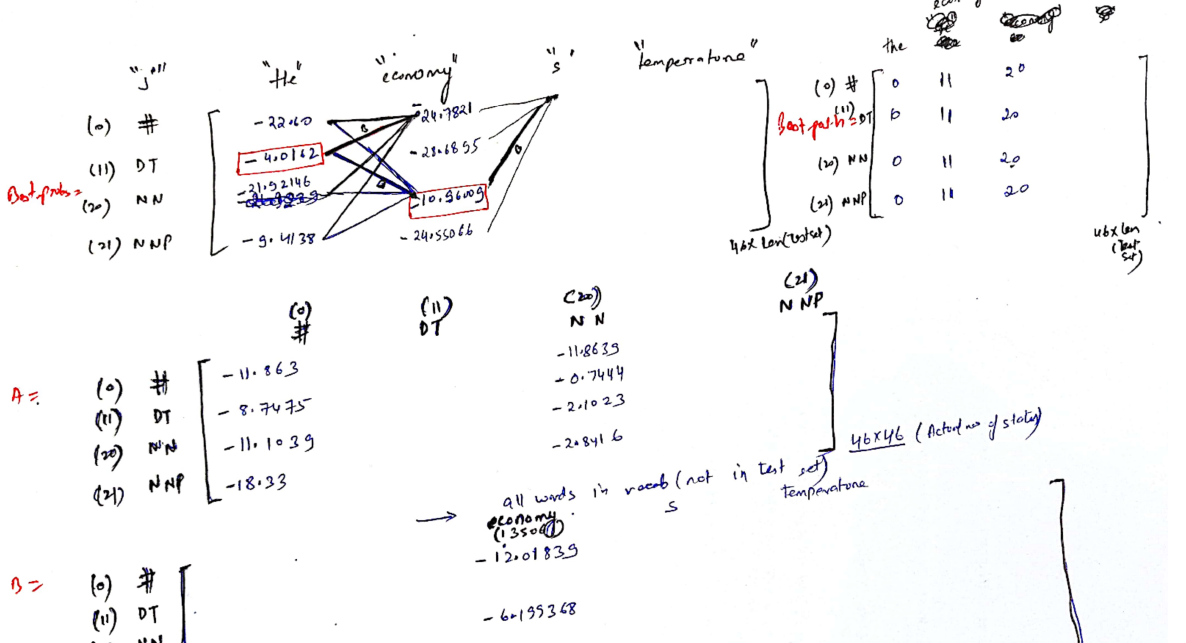

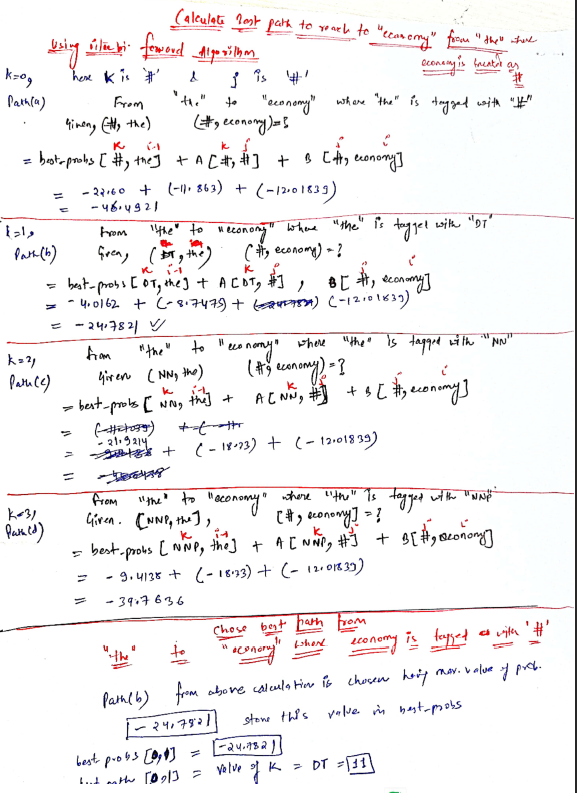

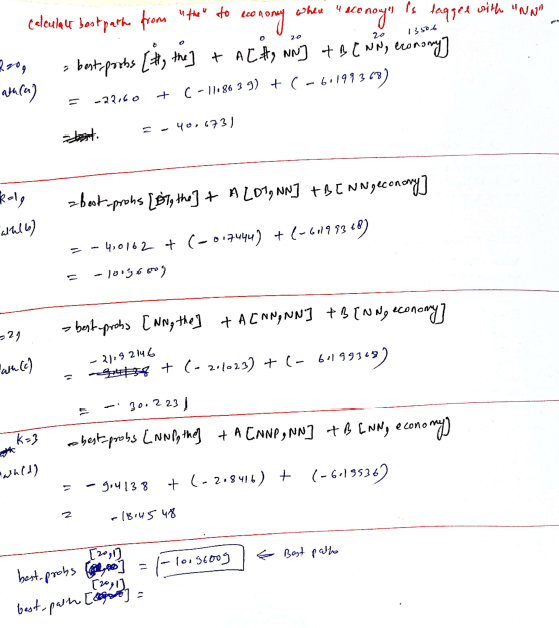

<a name='ex-06'></a>

### Exercise 06

Instructions: Implement the `viterbi_forward` algorithm and store the best_path and best_prob for every possible tag for each word in the matrices `best_probs` and `best_tags` using the pseudo code below.

`for each word in the corpus

    for each POS tag type that this word may be
    
        for POS tag type that the previous word could be
        
            compute the probability that the previous word had a given POS tag, that the current word has a given POS tag, and that the POS tag would emit this current word.
            
            retain the highest probability computed for the current word
            
            set best_probs to this highest probability
            
            set best_paths to the index 'k', representing the POS tag of the previous word which produced the highest probability `

Please use [math.log](https://docs.python.org/3/library/math.html) to compute the natural logarithm.

In [81]:
vocab['economy']

13506

In [112]:
print(states)

['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [81]:
print(states.index('#'))
print(states.index('DT'))
print(states.index('NNP'))
print(states.index('NN'))

0
11
21
20


### Printing few values from best_probs, first column (initialization step)

In [98]:
print(f"{best_probs[0,0]:.9f}") 
print(f"{best_probs[11,0]:.9f}")
print(f"{best_probs[20,0]:.9f}")
print(f"{best_probs[21,0]:.9f}")

-22.609826334
-4.016237414
-21.921467982
-9.413777772


### Printing few values from A, column 0 (#)

In [101]:
print(f"{math.log(A[0,0]):.9f}") 
print(f"{math.log(A[11,0]):.9f}")
print(f"{math.log(A[20,0]):.9f}")
print(f"{math.log(A[21,0]):.9f}")

-11.863906228
-8.747520123
-11.103968856
-18.331478379


### Printing few values from A, column 20 (NN)

In [103]:
print(f"{math.log(A[0,20]):.9f}") 
print(f"{math.log(A[11,20]):.9f}")
print(f"{math.log(A[20,20]):.9f}")
print(f"{math.log(A[21,20]):.9f}")

-11.863906228
-0.744491173
-2.102321662
-2.841678749


### Printing few values from B, column no (13506) which represents the word "economy"

In [102]:
print(f"{math.log(B[0,13506]):.9f}") 
print(f"{math.log(B[20,13506]):.9f}")

-12.018398791
-6.199368749


### Calculate few values for best_probs, column 1 row 0

In [54]:
# path 1 (# to economy) where economy will be tagged as '#'
best_probs[0,0] + math.log(A[0,0]) + math.log(B[0, 13506])

-46.49213135204481

In [55]:
# path 2 (DT to economy) where economy will be tagged as '#'
best_probs[11,0] + math.log(A[11,0]) + math.log(B[0, 13506])

-24.78215632717346

In [86]:
# path 3 (NN to economy) where economy will be tagged as '#'
best_probs[20,0] + math.log(A[20,0]) + math.log(B[0, 13506])

-45.04383562891515

In [56]:
# path 4 (NNP to economy) where economy will be tagged as '#'
best_probs[21,0] + math.log(A[21,0]) + math.log(B[0, 13506])

-39.763654941856814

### Calculate few values for best_probs, column 1 row 20

In [88]:
# path 1 (# to economy) where economy will be tagged as 'NN'
best_probs[0,0] + math.log(A[0,20]) + math.log(B[20, 13506])

-40.67310131043183

In [89]:
# path 2 (DT to economy) where economy will be tagged as 'NN'
best_probs[11,0] + math.log(A[11,20]) + math.log(B[20, 13506])

-10.960097336202963

In [107]:
# path 3 (NN to economy) where economy will be tagged as 'NN'
best_probs[20,0] + math.log(A[20,20]) + math.log(B[20, 13506])

-30.223158393156602

In [108]:
# path 4 (NN to economy) where economy will be tagged as 'NN'
best_probs[21,0] + math.log(A[21,20]) + math.log(B[20, 13506])

-18.45482527008444

### Print best_probs and best_paths values generated from viterbi algorithm

In [106]:
# now print all values of column 'ecomnomy' calculated from viterbi forward function
# cross the values obtained from our calculations above
print(f"{best_probs[0,1]:.9f}") 
# print(f"{best_probs[11,1]:.9f}")
print(f"{best_probs[20,1]:.9f}")
# print(f"{best_probs[21,1]:.9f}")

-24.782156327
-10.960097336


In [116]:
print(f"{best_paths[0,0]:.5f} {best_paths[0,1]:.5f} {best_paths[0,2]:.5f}")
print(f"{best_paths[11,0]:.5f} {best_paths[11,1]:.5f} {best_paths[11,2]:.5f}")
print(f"{best_paths[20,0]:.5f} {best_paths[20,1]:.5f} {best_paths[20,2]:.5f}")
print(f"{best_paths[21,0]:.5f} {best_paths[21,1]:.5f} {best_paths[21,2]:.5f}")

0.00000 11.00000 20.00000
0.00000 11.00000 20.00000
0.00000 11.00000 20.00000
0.00000 11.00000 20.00000


In [58]:
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab):
    '''
    Input: 
        A, B: The transiton and emission matrices respectively
        test_corpus: a list containing a preprocessed corpus
        best_probs: an initilized matrix of dimension (num_tags, len(corpus))
        best_paths: an initilized matrix of dimension (num_tags, len(corpus))
        vocab: a dictionary where keys are words in vocabulary and value is an index 
    Output: 
        best_probs: a completed matrix of dimension (num_tags, len(corpus))
        best_paths: a completed matrix of dimension (num_tags, len(corpus))
    '''
    # Get the number of unique POS tags (which is the num of rows in best_probs)
    num_tags = best_probs.shape[0]
    
    for i in range(1, len(test_corpus)): 
        for j in range(num_tags):
            best_prob_i = float("-inf")
            best_path_i = None
            for k in range(num_tags):
                prob = best_probs[k,i-1] + math.log(A[k,j]) + math.log(B[j,vocab[test_corpus[i]]])
                
                if prob > best_prob_i:
                    best_prob_i = prob
                    best_path_i = k
              
            best_probs[j,i] = best_prob_i
            best_paths[j,i] = best_path_i

    return best_probs, best_paths

Run the `viterbi_forward` function to fill in the `best_probs` and `best_paths` matrices.

**Note** that this will take a few minutes to run.  There are about 30,000 words to process.

In [59]:
# this will take a few minutes to run => processes ~ 30,000 words
best_probs, best_paths = viterbi_forward(A, B, prep, best_probs, best_paths, vocab)

In [117]:
print(f"{best_probs[0,1]:.9f}") 
print(f"{best_probs[0,4]:.9f}")

-24.782156327
-49.560126134


##### Expected Output

```CPP
best_probs[0,1]: -24.7822
best_probs[0,4]: -49.5601
```

<a name='3.3'></a>
## Part 3.3 Viterbi backward

Now you will implement the Viterbi backward algorithm.
- The Viterbi backward algorithm gets the predictions of the POS tags for each word in the corpus using the `best_paths` and the `best_probs` matrices.

The example below shows how to walk backwards through the best_paths matrix to get the POS tags of each word in the corpus. Recall that this example corpus has three words: "Loss tracks upward".

POS tag for 'upward' is `RB`
- Select the the most likely POS tag for the last word in the corpus, 'upward' in the `best_prob` table.
- Look for the row in the column for 'upward' that has the largest probability.
- Notice that in row 28 of `best_probs`, the estimated probability is -34.99, which is larger than the other values in the column.  So the most likely POS tag for 'upward' is `RB` an adverb, at row 28 of `best_prob`. 
- The variable `z` is an array that stores the unique integer ID of the predicted POS tags for each word in the corpus.  In array z, at position 2, store the value 28 to indicate that the word 'upward' (at index 2 in the corpus), most likely has the POS tag associated with unique ID 28 (which is `RB`).
- The variable `pred` contains the POS tags in string form.  So `pred` at index 2 stores the string `RB`.


POS tag for 'tracks' is `VBZ`
- The next step is to go backward one word in the corpus ('tracks').  Since the most likely POS tag for 'upward' is `RB`, which is uniquely identified by integer ID 28, go to the `best_paths` matrix in column 2, row 28.  The value stored in `best_paths`, column 2, row 28 indicates the unique ID of the POS tag of the previous word.  In this case, the value stored here is 40, which is the unique ID for POS tag `VBZ` (verb, 3rd person singular present).
- So the previous word at index 1 of the corpus ('tracks'), most likely has the POS tag with unique ID 40, which is `VBZ`.
- In array `z`, store the value 40 at position 1, and for array `pred`, store the string `VBZ` to indicate that the word 'tracks' most likely has POS tag `VBZ`.

POS tag for 'Loss' is `NN`
- In `best_paths` at column 1, the unique ID stored at row 40 is 20.  20 is the unique ID for POS tag `NN`.
- In array `z` at position 0, store 20.  In array `pred` at position 0, store `NN`.

<a name='ex-07'></a>
### Exercise 07
Implement the `viterbi_backward` algorithm, which returns a list of predicted POS tags for each word in the corpus.

- Note that the numbering of the index positions starts at 0 and not 1. 
- `m` is the number of words in the corpus.  
    - So the indexing into the corpus goes from `0` to `m - 1`.
    - Also, the columns in `best_probs` and `best_paths` are indexed from `0` to `m - 1`


**In Step 1:**       
Loop through all the rows (POS tags) in the last entry of `best_probs` and find the row (POS tag) with the maximum value.
Convert the unique integer ID to a tag (a string representation) using the dictionary `states`.  

Referring to the three-word corpus described above:
- `z[2] = 28`: For the word 'upward' at position 2 in the corpus, the POS tag ID is 28.  Store 28 in `z` at position 2.
- states(28) is 'RB': The POS tag ID 28 refers to the POS tag 'RB'.
- `pred[2] = 'RB'`: In array `pred`, store the POS tag for the word 'upward'.

**In Step 2:**  
- Starting at the last column of best_paths, use `best_probs` to find the most likely POS tag for the last word in the corpus.
- Then use `best_paths` to find the most likely POS tag for the previous word. 
- Update the POS tag for each word in `z` and in `preds`.

Referring to the three-word example from above, read best_paths at column 2 and fill in z at position 1.  
`z[1] = best_paths[z[2],2]`  

The small test following the routine prints the last few words of the corpus and their states to aid in debug.

In [ ]:
def viterbi_backward(best_probs, best_paths, corpus, states):
    '''
    This function returns the best path.
    
    '''
    # Get the number of words in the corpus
    # which is also the number of columns in best_probs, best_paths
    m = best_paths.shape[1] 
    
    # Initialize array z, same length as the corpus
    z = [None] * m
    
    # Get the number of unique POS tags
    num_tags = best_probs.shape[0]
    
    # Initialize the best probability for the last word
    best_prob_for_last_word = float('-inf')
    
    # Initialize pred array, same length as corpus
    pred = [None] * m
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    ## Step 1 ##
    
    # Go through each POS tag for the last word (last column of best_probs)
    # in order to find the row (POS tag integer ID) 
    # with highest probability for the last word
    for k in range(num_tags): # complete this line

        # If the probability of POS tag at row k 
        # is better than the previosly best probability for the last word:
        if best_probs[k,-1]>best_prob_for_last_word: # complete this line
            
            # Store the new best probability for the lsat word
            best_prob_for_last_word = best_probs[k,-1]
    
            # Store the unique integer ID of the POS tag
            # which is also the row number in best_probs
            z[m - 1] = k
            
    # Convert the last word's predicted POS tag
    # from its unique integer ID into the string representation
    # using the 'states' dictionary
    # store this in the 'pred' array for the last word
    pred[m - 1] = states[k]
    
    ## Step 2 ##
    # Find the best POS tags by walking backward through the best_paths
    # From the last word in the corpus to the 0th word in the corpus
    for i in range(len(corpus)-1, -1, -1): # complete this line
        
        # Retrieve the unique integer ID of
        # the POS tag for the word at position 'i' in the corpus
        pos_tag_for_word_i = best_paths[np.argmax(best_probs[:,i]),i]
        
        # In best_paths, go to the row representing the POS tag of word i
        # and the column representing the word's position in the corpus
        # to retrieve the predicted POS for the word at position i-1 in the corpus
        z[i - 1] = best_paths[pos_tag_for_word_i,i]
        
        # Get the previous word's POS tag in string form
        # Use the 'states' dictionary, 
        # where the key is the unique integer ID of the POS tag,
        # and the value is the string representation of that POS tag
        pred[i - 1] = states[pos_tag_for_word_i]
        
     ### END CODE HERE ###
    return pred

In [ ]:
# Run and test your function
pred = viterbi_backward(best_probs, best_paths, prep, states)
m=len(pred)
print('The prediction for pred[-7:m-1] is: \n', prep[-7:m-1], "\n", pred[-7:m-1], "\n")
print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", prep[0:7])

**Expected Output:**   

```CPP
The prediction for prep[-7:m-1] is:  
 ['see', 'them', 'here', 'with', 'us', '.']  
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.']   
The prediction for pred[0:8] is:    
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN']   
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken'] 
```

Now you just have to compare the predicted labels to the true labels to evaluate your model on the accuracy metric!

<a name='4'></a>
# Part 4: Predicting on a data set

Compute the accuracy of your prediction by comparing it with the true `y` labels. 
- `pred` is a list of predicted POS tags corresponding to the words of the `test_corpus`. 

In [ ]:
print('The third word is:', prep[3])
print('Your prediction is:', pred[3])
print('Your corresponding label y is: ', y[3])

<a name='ex-08'></a>
### Exercise 08

Implement a function to compute the accuracy of the viterbi algorithm's POS tag predictions.
- To split y into the word and its tag you can use `y.split()`. 

In [ ]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: compute_accuracy
def compute_accuracy(pred, y):
    '''
    Input: 
        pred: a list of the predicted parts-of-speech 
        y: a list of lines where each word is separated by a '\t' (i.e. word \t tag)
    Output: 
        
    '''
    num_correct = 0
    total = 0
    
    # Zip together the prediction and the labels
    for prediction, y in zip(pred, y):
        ### START CODE HERE (Replace instances of 'None' with your code) ###
        # Split the label into the word and the POS tag
        word_tag_tuple = y.split()
        
        # Check that there is actually a word and a tag
        # no more and no less than 2 items
        if len(word_tag_tuple)!=2: # complete this line
            continue 

        # store the word and tag separately
        word, tag = word_tag_tuple
        
        # Check if the POS tag label matches the prediction
        if prediction == tag: # complete this line
            
            # count the number of times that the prediction
            # and label match
            num_correct += 1
            
        # keep track of the total number of examples (that have valid labels)
        total += 1
        
        ### END CODE HERE ###
    return num_correct/total

In [ ]:
print(f"Accuracy of the Viterbi algorithm is {compute_accuracy(pred, y):.4f}")

##### Expected Output

```CPP
Accuracy of the Viterbi algorithm is 0.9531
```

Congratulations you were able to classify the parts-of-speech with 95% accuracy. 